### Copyright (C) Infineon Technologies AG 2025
 
Use of this file is subject to the terms of use agreed between (i) you or the company in which ordinary course of 
business you are acting and (ii) Infineon Technologies AG or its licensees. If and as long as no such terms of use
are agreed, use of this file is subject to following:
 
This file is licensed under the terms of the Boost Software License. See the LICENSE file in the root of this repository
for complete details.

# Anomaly Detection with MLP Autoencoder

This notebook demonstrates how to build and train a Multi-Layer Perceptron (MLP) based autoencoder for anomaly detection using the Controlled Anomalies Time Series (CATS) dataset and the helper functions from `modelling_helper.py`.

## Introduction

Anomaly detection is a critical capability for monitoring complex systems and identifying unusual patterns that may indicate equipment failures, security breaches, or operational issues. In industrial applications, effective anomaly detection provides:

- **Predictive maintenance** - Early detection of equipment degradation before catastrophic failure
- **Quality assurance** - Identification of process deviations that affect product quality
- **Security monitoring** - Detection of unusual patterns that may indicate cyber attacks or system intrusions
- **Operational optimization** - Identification of inefficient or suboptimal system behaviors
- **Cost reduction** - Prevention of costly downtime through early anomaly identification

## Autoencoder Approach

This notebook uses an **autoencoder neural network** approach for anomaly detection:

- **Training Phase**: The autoencoder learns to reconstruct normal system behavior from multivariate time series data
- **Detection Phase**: Anomalies are identified by measuring reconstruction error - high reconstruction error indicates anomalous behavior
- **Unsupervised Learning**: The model learns normal patterns without requiring labeled anomalous examples during training

## Notebook Structure

This notebook walks through the complete anomaly detection workflow:

1. **Data Loading & Exploration** - Load the CATS dataset, understand its structure, and visualize time series patterns
2. **Data Preprocessing** - Normalize features, create time series sequences, and prepare training/validation splits
3. **Model Definition** - Build an MLP-based autoencoder architecture optimized for time series reconstruction
4. **Model Training** - Train the autoencoder on normal data with early stopping and learning rate scheduling
5. **Model Evaluation** - Assess reconstruction performance and validate anomaly detection capability
6. **Model Export** - Convert the trained model to ONNX format for deployment
7. **Hardware Deployment** - Compile the model for AURIX&trade; microcontroller deployment
8. **Performance Analysis** - Evaluate execution timing and resource usage on target hardware

The methodologies demonstrated are applicable to various industrial monitoring scenarios including manufacturing processes, power systems, transportation networks, and IoT sensor networks.

## Import Libraries and Helper Functions

In [1]:
import sys
import os

# Add parent directory to path for importing central scripts
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Import project modules
import CentralScripts.helper_functions as cs
import modelling_helper as mh

# Load and Visualize Data

## Dataset: Controlled Anomalies Time Series (CATS)

This notebook uses the **Controlled Anomalies Time Series (CATS) Dataset** for anomaly detection model training. The CATS dataset is a synthetic multivariate time series dataset specifically designed for benchmarking anomaly detection algorithms.

**Dataset Source:** [https://zenodo.org/records/8338435](https://zenodo.org/records/8338435)

### Key Dataset Characteristics:

- **Multivariate:** 17 variables including:
  - 4 Control commands/actuations
  - 3 Environmental stimuli/external forces  
  - 10 Telemetry sensor readings (position, temperature, pressure, etc.)

- **Scale:** 5 million timestamps at 1Hz sampling frequency
  - First 1 million: Nominal (normal) behavior for learning baseline
  - Last 4 million: Mixed nominal and anomalous segments for evaluation

- **Anomalies:** 200 precisely labeled anomalous segments with different types and known ground truth
- **Root Cause Analysis:** Metadata includes root cause channels and affected channels for each anomaly
- **Clean Signals:** Noise-free data allows controlled robustness testing

The dataset simulates a complex dynamical system and is particularly suitable for:
- Semi-supervised anomaly detection (novelty detection)
- Unsupervised anomaly detection (outlier detection)  
- Root cause analysis and explainability evaluation
- Algorithm robustness testing

### Citation

```
Patrick Fleith. (2023). Controlled Anomalies Time Series (CATS) Dataset (Version 2) 
[Data set]. Solenix Engineering GmbH. https://doi.org/10.5281/zenodo.8338435
```

In [2]:
train, test, meta_data = mh.load_data(
    data_path="data/data.csv", meta_path="data/metadata.csv"
)

Loading file: data/data.csv
Loading file: data/metadata.csv


## Data Overview

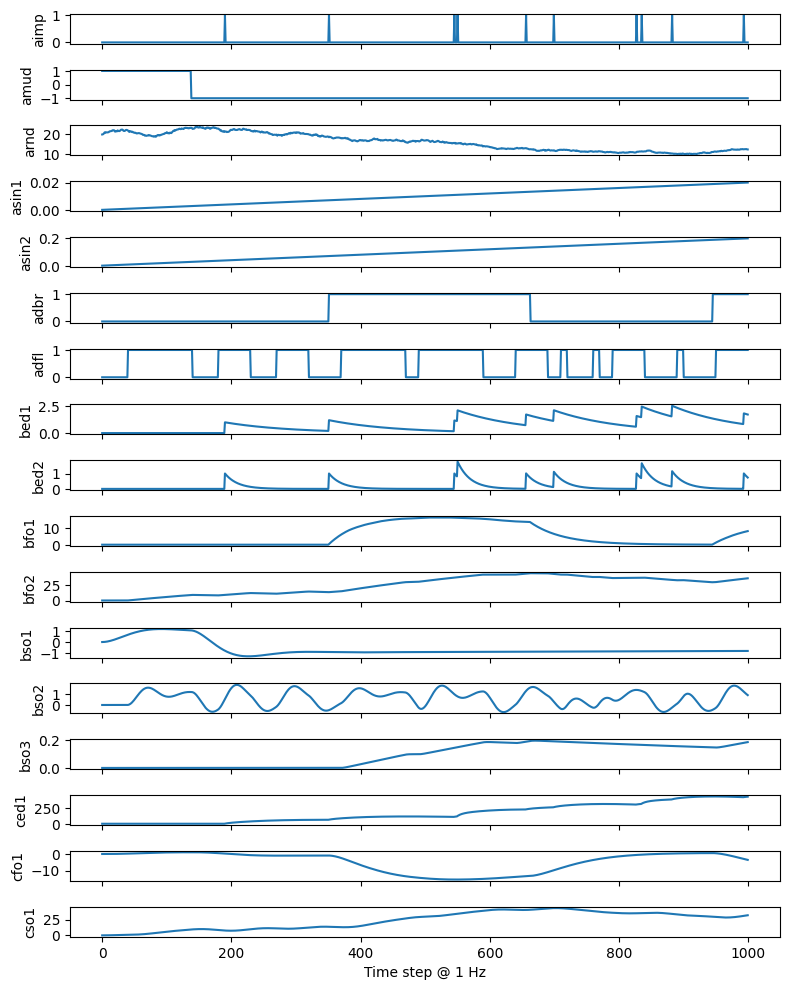

In [3]:
mh.plot_time_steps(
    df=train,
    n_steps=1000,
)

# Prepare input sequences for model training

- `sequence_length` defines the number of time steps takes as input for the model. Adjust this to see its effect on detection quality. Larger `seqence_length` requires a larger input layer of the auto encoder and therefore results in overall larger models requiring more memory.
- From the train data random sequences of length `sequence_length` are selected. A higher number ensures better coverage of the normal behaviour of the train data but increases training time.
- Input data is proved as a tensor of sequences with shape `n_samples * sequence_length * n_features`

In [4]:
from sklearn.model_selection import train_test_split

train_scaled, scaler = mh.normalize_data(df=train)
test_scaled, scaler = mh.normalize_data(df=test, scaler=scaler)

# seelct the length of sequences
sequence_length = 30

sequences = mh.sample_sequences(
    df=train_scaled,
    sequence_length=sequence_length,
    n_samples=10000,  # Use a smaller number for quicker testing
)

# Split sequences: 95% train, 5% validation
sequences_train, sequences_val = train_test_split(
    sequences, test_size=0.05, random_state=42
)

print(
    f"Train sequences: {len(sequences_train)}, Validation sequences: {len(sequences_val)}"
)

Train sequences: 9500, Validation sequences: 500


# Build an MLP based autoencoder

- Set the number of layers: it will be the same number on both encoder and decoder sides. A single layer proved to get good results
- The bottleneck defines the compression of the data. Play with this number to see what works best.
- As loss the Mean Squared Error (MSE) is used. Model performance later is assessed using this metric.

In [5]:
model = mh.mlp_autoencoder(
    input_dim=sequences_train.shape[1] * sequences_train.shape[2],
    bottleneck=64,
    layers=1,
    p_drop=0.1,
)

=== MLP Autoencoder Architecture ===
Input dimension: 510
Bottleneck size: 64
Compression ratio: 0.125
Encoder layers: 1



Model: "MLP_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 510)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_1 (Dense)         │ (None, 64)             │        32,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_dropout (Dropout)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_1 (Dense)         │ (None, 510)            │        33,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_1 (Dropout)     │ (None, 510)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction_output (Dense)   │ (None, 510)            │       260,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,624 (1.26 MB)

 Trainable params: 330,624 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

None


# Train the model

- The training process uses early stopping to avoid overfitting.
- To ensure proper convergence learning rate reduction is used when training stalls.

Epoch 1/3
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5714 - val_loss: 0.2182 - learning_rate: 0.0010
Epoch 2/3
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2872 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 3/3
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2470 - val_loss: 0.1536 - learning_rate: 0.0010


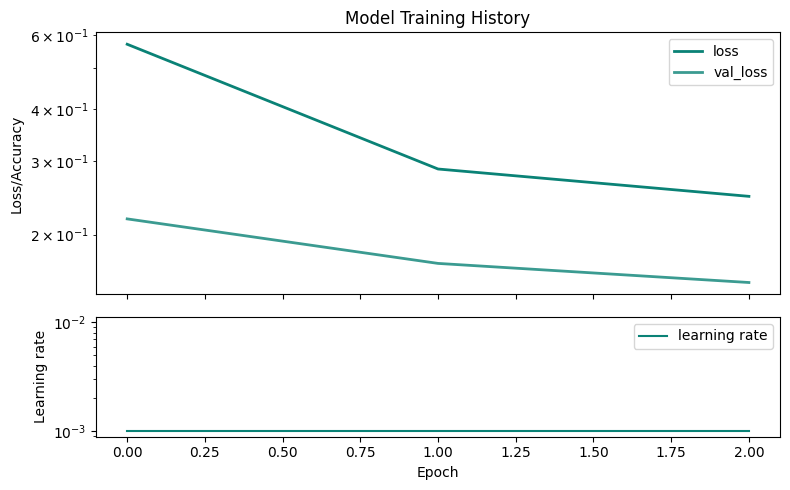

In [ ]:
X_train = sequences_train.reshape(sequences_train.shape[0], -1)
X_val = sequences_val.reshape(sequences_val.shape[0], -1)

history = model.fit(
    x=X_train,
    y=X_train,
    epochs=10,
    batch_size=64,
    validation_data=[X_val, X_val],
    callbacks=mh.get_callbacks(),
)
cs.plot_training_history(history)

# Model evaluation

- Make model predictions on the train & test data sets and calculate the reconstruction error as Mean Squared Error
- Compare the distrubtions over the MSE for train and test data -> both distributions should strongly overlap!
- Define an anomaly threshold `thresh` for the MSE above which to consider a sequence as anomalous. Typically, this is set to the 95th or above percentile of the MSE of the train or test set. Adjsuting this thresholds shifts the balance between false positive and false negative detections.
- Check model functionality on anomaly data

In [7]:
import numpy as np
import pandas as pd

y_train = model.predict(X_train)
err_train = np.sum((y_train - X_train) ** 2, axis=1)

res_train = pd.DataFrame({"MSE": err_train, "Train_test": "Train", "Label": "clean"})

test_scaled, scaler = mh.normalize_data(df=test, scaler=scaler)

sequences_test = mh.sample_sequences(
    df=test_scaled,
    sequence_length=sequence_length,
    n_samples=5000,
)

X_test = sequences_test.reshape(sequences_test.shape[0], -1)

y_test = model.predict(X_test)
err_test = np.sum((y_test - X_test) ** 2, axis=1)

res_test = pd.DataFrame({"MSE": err_test, "Train_test": "Test", "Label": "clean"})

res = pd.concat([res_train, res_test], ignore_index=True)


quantile = 0.95  # 95th percentile, adjust as needed
threshold = res_train["MSE"].quantile(quantile)

print(f"Set anomaly threshold at: {threshold:.2f}")

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Set anomaly threshold at: 202.51


## Plot reconstruction error distributions

- Mean squared error (MSE) as metric as used for model training loss.
- MSE for anomaly free data from train and test data.

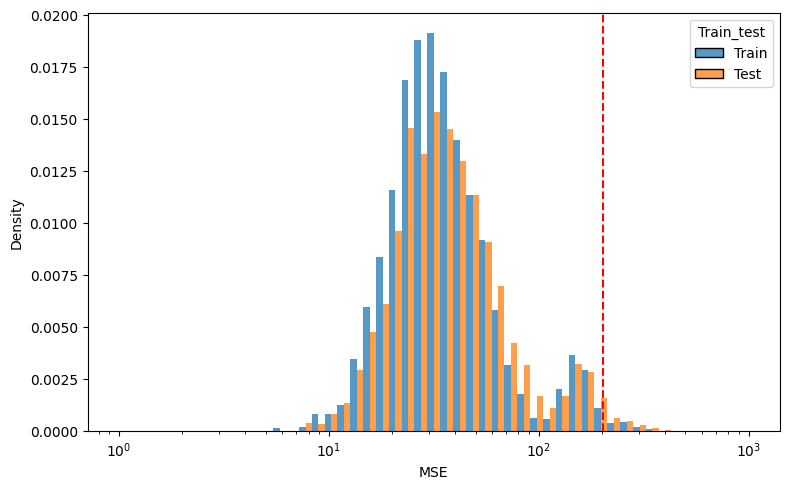

In [8]:
mh.plot_reconstruction_error(res, threshold)

## Check detection quality

- Plot an anomalous time series.
- The meta data data frame contains the information for 200 labelled anomalies from the test data set. Select one and see the detection quality.
- Calculate the MSE at each time point

In [9]:
meta_data.head()

,start_time,end_time,root_cause,affected,category
0,2023-01-12 15:11:45,2023-01-12 15:20:05,bso3,['cfo1'],12
1,2023-01-12 16:27:46,2023-01-12 17:51:06,bso3,['cfo1'],1
2,2023-01-12 18:19:35,2023-01-12 18:36:15,bfo2,['cso1'],8
3,2023-01-12 20:46:32,2023-01-12 20:51:32,bed2,['ced1'],7
4,2023-01-13 05:57:10,2023-01-13 06:02:10,bfo1,['cfo1'],9


In [10]:
import re

# select an anomaly from the meta data (0 - 199)
ii = 102

start = meta_data["start_time"][ii]
start = pd.to_datetime(start)
end = meta_data["end_time"][ii]
end = end = pd.to_datetime(end)

root_cause = meta_data["root_cause"][ii]
affected = meta_data["affected"][ii]
affected = re.findall(r"'([^']*)'", affected)[0]

print(f"Anomaly from {start} to {end}, root cause: {root_cause}, affected: {affected}")

# select the corresponding data from the test set
tt = test.copy()
tt["timestamp"] = pd.to_datetime(tt["timestamp"])
tt = tt.set_index("timestamp")

rows = tt.loc[start:end]
rows_scaled = mh.normalize_data(df=rows, scaler=scaler)[0]

anomaly_data = {
    "rows": rows,
    "rows_scaled": rows_scaled,
    "start": start,
    "end": end,
    "root_cause": root_cause,
    "affected": affected,
}

Anomaly from 2023-02-05 00:05:28 to 2023-02-05 00:13:48, root cause: bfo2, affected: cso1


## Create sequences of anomalous data for model predictions and calculate reconstruction error

- Sequences as rolling window over the selected anomalous time series.

In [11]:
seqs = mh.sequential_sequences(
    df=rows_scaled,
    sequence_length=sequence_length,
)

y_pred = model.predict(seqs.reshape(seqs.shape[0], -1))
err = np.sum((y_pred - seqs.reshape(seqs.shape[0], -1)) ** 2, axis=1)

err = pd.DataFrame({"MSE": err, "timestamp": rows.index[sequence_length - 1 :]})

anomaly_data["err"] = err

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


## Plot results

- At each time point plot the reconstruction error and compare it against the selected threshold to lable anomalous time points

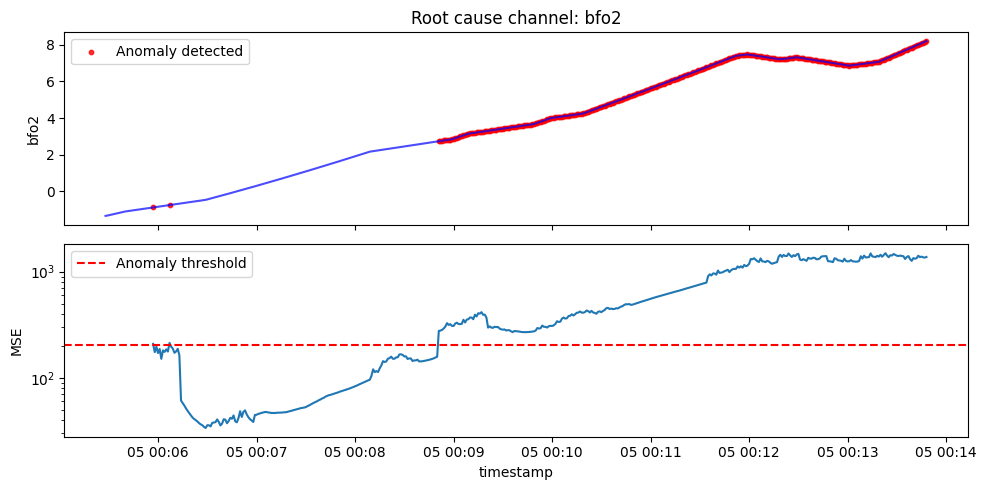

In [12]:
mh.plot_anomaly_detection(anomaly_data, threshold)

# Export Model to ONNX

- Generate a model name based on its architecture and loss
- Save the model together with a test in- & output

In [13]:
test_loss = model.evaluate(X_test, X_test, verbose=0)

model_name = mh.generate_model_name(model, test_loss)

origin = "tf"

input_target = sequences_train[0].reshape(-1).astype(np.float32)
output_target = cs.get_predictions(origin, model, input_target)

cs.save_all(model_name, input_target, output_target, model, origin)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Directory already exists: out/mlp_autoencoder_model_layers_4_param_330624_loss_0-24/test_mlp_autoencoder_model_layers_4_param_330624_loss_0-24


# Convert Model for AURIX&trade; TC3x/TC4x deployment

- Make sure the docker container with conversion tools is running
- Submit the model together with test data to the container and download the generated code, binary and log files.
- Results are saved in the `out/<model_name>/test_<model_name>/<target>/` folder

In [14]:
cs.ensure_docker_container()

Docker container '' (from image 'docker-atv-sae-ai-public-registry.vih.infineon.com/tc_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


In [15]:
from CentralScripts.python_flask_client import CallTools

model_folder, onnx_model_file = cs.get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

Target folder out/mlp_autoencoder_model_layers_4_param_330624_loss_0-24/test_mlp_autoencoder_model_layers_4_param_330624_loss_0-24/TC3 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
Target folder out/mlp_autoencoder_model_layers_4_param_330624_loss_0-24/test_mlp_autoencoder_model_layers_4_param_330624_loss_0-24/TC4 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


## Simulated execution timing

- For each node in the neural network the number of clock cycles is extracted from the log file and plotted.
- You can inspect which node is a computational bottleneck and adjust your network if wanted.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


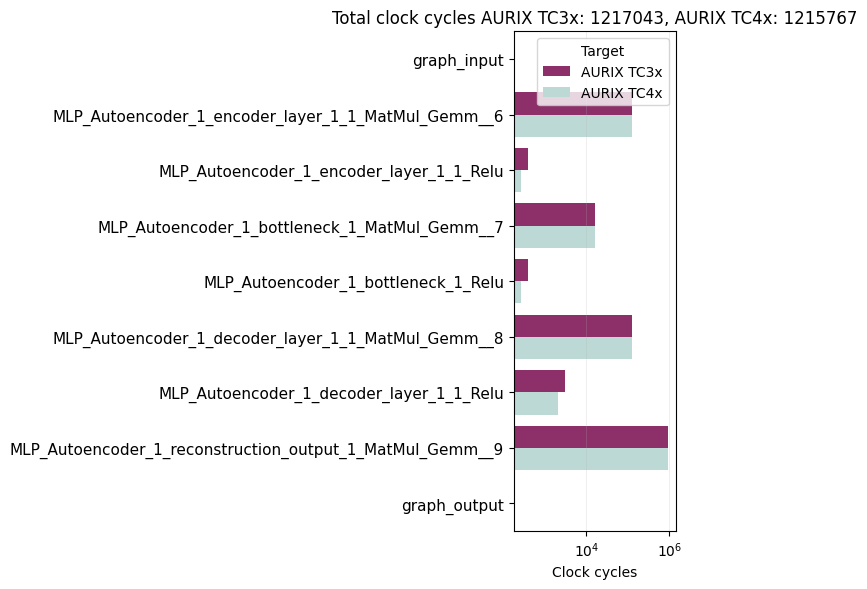

In [16]:
cs.plot_execution_timing(model_name)